<a href="https://colab.research.google.com/github/llalice/AI-Driven-Detection-of-Pneumonia-Using-Chest-X-Ray-Images/blob/main/7007_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U langdetect spacy scikit-learn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 51.5 MB/s eta 0:00:00
^C


# Data Preprocessing (Description Column)

In [ ]:
import pandas as pd
import re
from langdetect import detect
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/MyDrive/jobstreet_all_job_dataset.csv'
df = pd.read_csv(file_path)
print(f" Initial record count: {len(df)}")

# Remove duplicates
df.drop_duplicates(inplace=True)
print(f" After removing duplicates: {len(df)}")

# Drop rows with missing descriptions
df = df[df['descriptions'].notna()]
print(f" After dropping empty descriptions: {len(df)}")


**Description**: After checking, there were no duplicate or empty job descriptions. So all records still valid for further analysis.

In [ ]:
fill_cols = ['salary', 'role', 'type', 'job_title', 'company', 'job_id',
             'location', 'category', 'subcategory', 'listingDate']
for col in fill_cols:
    df[col] = df[col].fillna('unknown')
df.head()


In [ ]:
df['listingDate'] = pd.to_datetime(df['listingDate'], errors='coerce')
df.head()

In [ ]:
def parse_salary(salary):
    try:
        numbers = re.findall(r'\d+', str(salary).replace(',', ''))
        numbers = list(map(int, numbers))
        if len(numbers) >= 2:
            return sum(numbers[:2]) / 2
        elif numbers:
            return numbers[0]
    except:
        return None
    return None
df['parsed_salary'] = df['salary'].apply(parse_salary)
df.head()


In [ ]:
nlp = spacy.load("en_core_web_sm")
def clean_text(text):
    if pd.isna(text): return ""
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and len(token.text) > 1 and token.text not in STOP_WORDS
    ]
    return ' '.join(tokens)
df['clean_descriptions'] = df['descriptions'].apply(clean_text)


In [ ]:
df = df[df['clean_descriptions'].apply(lambda x: 30 < len(x.split()) < 500)]
print(f" After filtering length-extreme descriptions: {len(df)}")
df.head()

In [ ]:
output_path = '/content/drive/MyDrive/jobstreet_cleaned_final.csv'
df.to_csv(output_path, index=False)
print(f" Cleaned dataset saved to: {output_path}")


# Data Preprocessing (Salary Column)

In [ ]:
import re
import pandas as pd

EXCHANGE_RATES = {
    'RM': 1.0,        # Malaysian Ringgit (base currency)
    'MYR': 1.0,
    '฿': 0.13,        # Thai Baht: 1 THB ≈ 0.13 RM
    'S$': 3.29,       # Singapore Dollar: 1 SGD ≈ 3.29 RM
    '$': 4.2,         # US Dollar: 1 USD ≈ 4.2 RM
    '€': 4.8,         # Euro: 1 EUR ≈ 4.8 RM
    '£': 5.742,       # British Pound: 1 GBP ≈ 5.742 RM
    '¥': 0.0294,      # Japanese Yen: 1 JPY ≈ 0.0294 RM
    'RMB': 0.5892,    # Chinese Yuan: 1 CNY ≈ 0.5892 RM
    'Rp': 0.00028,    # Indonesian Rupiah: 10,000 IDR ≈ 2.8 RM
}

def parse_salary(salary_str):
    if pd.isna(salary_str) or not isinstance(salary_str, str):
        return {'lower_rm': 0, 'upper_rm': 0, 'monthly_avg_rm': 0}

    original_str = salary_str
    salary_str = salary_str.strip().replace(' ', '')

    if not any(c.isdigit() for c in salary_str):
        return {'lower_rm': 0, 'upper_rm': 0, 'monthly_avg_rm': 0}

    lower = upper = None
    period = 'month'
    multiplier = 1
    currency = 'RM'

    for curr in EXCHANGE_RATES:
        if curr in original_str:
            currency = curr
            break

    if any(x in original_str.lower() for x in ['year', 'p.a.', 'annum', '年']):
        period = 'year'
    elif any(x in original_str.lower() for x in ['hour', '/hr', '小时']):
        period = 'hour'
    elif any(x in original_str.lower() for x in ['day', '/day', '天']):
        period = 'day'

    if 'k' in original_str.lower():
        multiplier = 1000
    elif '万' in original_str or 'w' in original_str.lower():
        multiplier = 10000

    salary_str_cleaned_for_range = re.sub(r'[^\d.,~—\-–]', '', original_str.strip().replace(' ', '').lower())

    lower = upper = None
    range_separators = ['-', '–', '—', '~', 'to']
    for sep in range_separators:
        if sep in original_str.lower():
            parts = re.split(sep, original_str, flags=re.IGNORECASE)
            if len(parts) == 2:
                try:
                    part1 = parts[0].strip()
                    part1_multiplier = 1
                    if 'k' in part1.lower():
                        part1_multiplier = 1000
                        part1 = part1.lower().replace('k', '')
                    elif '万' in part1 or 'w' in part1.lower():
                        part1_multiplier = 10000
                        part1 = part1.lower().replace('万', '').replace('w', '')

                    num1_match = re.search(r'[\d,]+\.?\d*', part1)
                    lower = float(num1_match.group().replace(',', '')) * part1_multiplier if num1_match else None

                    part2 = parts[1].strip()
                    part2_multiplier = 1

                    if 'k' in part2.lower():
                        part2_multiplier = 1000
                        part2 = part2.lower().replace('k', '')
                    elif '万' in part2 or 'w' in part2.lower():
                        part2_multiplier = 10000
                        part2 = part2.lower().replace('万', '').replace('w', '')

                    num2_match = re.search(r'[\d,]+\.?\d*', part2)
                    upper = float(num2_match.group().replace(',', '')) * part2_multiplier if num2_match else None

                    if lower is not None and upper is not None:
                        break
                except (ValueError, AttributeError):
                    continue

    if lower is None or upper is None:
        try:
            num_match = re.search(r'[\d,]+\.?\d*', original_str)
            if num_match:
                num = float(num_match.group().replace(',', '')) * multiplier
                lower = upper = num
            else:
                return {'lower_rm': 0, 'upper_rm': 0, 'monthly_avg_rm': 0}
        except ValueError:
            return {'lower_rm': 0, 'upper_rm': 0, 'monthly_avg_rm': 0}

    # Convert to monthly salary
    if period == 'year' and lower is not None:
        lower = lower / 12
        upper = upper / 12
    elif period == 'day' and lower is not None:
        lower = lower * 21.75
        upper = upper * 21.75
    elif period == 'hour' and lower is not None:
        lower = lower * 8 * 21.75  # 8 hours/day, 21.75 working days/month
        upper = upper * 8 * 21.75

    exchange_rate = EXCHANGE_RATES.get(currency, 1.0)
    lower_rm = round(lower * exchange_rate, 2) if lower is not None else 0
    upper_rm = round(upper * exchange_rate, 2) if upper is not None else 0
    monthly_avg_rm = round((lower_rm + upper_rm) / 2, 2) if (lower_rm and upper_rm) else 0

    return {
        'original': original_str,
        'currency': currency,
        'lower_original': lower,
        'upper_original': upper,
        'lower_rm': lower_rm,
        'upper_rm': upper_rm,
        'monthly_avg_rm': monthly_avg_rm
    }


In [ ]:
# test
test_cases = [
    "$10000.0 - $12000.0 p.m.",
    "$102k - $120k p.a.",
    "$10000.0 - $16k p.m.",
    "$2,300 – $3,200 per month",
    "RM 5,000-8,000",
    "S$6k to S$8k",
    "¥500,000 per year",
    "面议",
    "$5000.0 - $11k p.m. + $5k - $11,000",
    "RM 1,000 per month",
    "MYR 17000- MYR 20000 monthly",
    "MYR 18,000 - 21,000",
    "Competitive Remuneration & Benefits",
    "Basic + 13 Months + Performance bonuses.",
    "From 48000 to 72000 MYR per year",
    "Kuala Lumpur",
    "RM 2,500 – RM 3,500 per year",
    "RM 100,000 per year",
    "RM 10 – RM 15 per hour",
    "฿40,000 – ฿60,000 per month",
    "x 13 months",
    "up to MYR156,000 per annum",
    "฿46,000 – ฿67,000 per month"
]

results = []
for case in test_cases:
    parsed = parse_salary(case)
    results.append({
        'original': case,
        'lower_rm': parsed['lower_rm'],
        'upper_rm': parsed['upper_rm'],
        'monthly_avg_rm': parsed['monthly_avg_rm']
    })

pd.DataFrame(results)

In [ ]:
file_path = '/content/drive/MyDrive/jobstreet_cleaned_final.csv'
df = pd.read_csv(file_path)

salary_data = df['salary'].apply(parse_salary)

df = pd.concat([
    df,
    pd.DataFrame(salary_data.tolist())
], axis=1)

In [ ]:
output_path = '/content/drive/MyDrive/jobstreet_processed_salary.csv'
df.to_csv(output_path, index=False)
print("Successfully:", output_path)

print(df[['salary', 'currency', 'lower_rm', 'upper_rm', 'monthly_avg_rm']].head(30))

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn

from sklearn.metrics import f1_score, multilabel_confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import time
import datetime
import re
from scipy.stats import pearsonr

# General Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_NAME = "prajjwal1/bert-tiny"
DATA_PATH = "/content/drive/MyDrive"
MODEL_SAVE_PATH = f"{DATA_PATH}/best_model.pt"
label_cols = ['label_skill', 'label_language', 'label_experience', 'label_benefit', 'label_warning']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv(f"{DATA_PATH}/jobstreet_processed_salary.csv")

# Feature Engineering

###Define a list of **base keywords**

In [ ]:
def clean_keywords(keyword_list):
    seen = set()
    result = []
    for keyword in keyword_list:
        keyword_lower = keyword.lower().strip()
        if len(keyword_lower) > 2 and keyword_lower not in seen:
            seen.add(keyword_lower)
            result.append(keyword_lower)
    return sorted(result)

base_keywords = {
    'skill': clean_keywords([
        'python', 'java', 'sql', 'html', 'css', 'javascript', 'react', 'nodejs', 'laravel', 'django',
        'git', 'microsoft office', 'excel', 'powerpoint', 'cloud computing', 'data analysis',
        'data entry', 'report generation', 'dataset annotation', 'prompt engineering', 'model fine-tuning',
        'accounting', 'bookkeeping', 'financial reporting', 'financial analysis', 'accounting software',
        'tax computation', 'loan processing', 'credit analysis', 'financial compliance',
        'administration', 'admin support', 'payroll processing', 'recruitment', 'recruitment skills',
        'hr operations', 'human resource', 'training coordination',
        'customer service', 'complaint handling', 'order processing', 'sales strategy',
        'negotiation skills', 'presentation skills', 'sales target', 'crm tools',
        'digital marketing', 'content creation', 'seo', 'seo strategy', 'facebook ads',
        'telemarketing', 'cold calling', 'copywriting', 'email marketing',
        'adobe photoshop', 'photo editing', 'video editing', 'video production',
        'canva', 'illustration', 'storyboarding', 'script writing', 'motion graphics',
        'autocad', 'solidworks', 'mechanical repair', 'autocad drafting',
        'technical drawing', 'machine maintenance', 'electrical troubleshooting', 'wiring skills',
        'nursing', 'patient care', 'vital signs monitoring', 'first aid certified',
        'hospital support', 'medication administration', 'medical record keeping',
        'teaching', 'lesson planning', 'classroom management', 'student management', 'online teaching',
        'inventory control', 'inventory management', 'packing', 'stock take',
        'warehouse operations', 'forklift driving', 'delivery planning', 'logistics arrangement',
        'shipping documents',
        'legal research', 'contract drafting', 'legal documentation', 'compliance audit',
        'site supervision', 'quantity surveying', 'construction safety',
        'food preparation', 'guest service', 'table service', 'hotel operations',
        'menu knowledge', 'cleaning duties', 'order taking',
        'assembly line', 'machine operation', 'quality control', 'quality assurance',
        'cashiering', 'stock taking', 'pos system', 'retail sales', 'pos handling',
        'aircraft maintenance', 'flight operations', 'flight simulation',
        'policy drafting', 'public service', 'statistical reporting',
        'crop monitoring', 'pesticide application', 'soil testing', 'waste management',
        'environmental monitoring', 'impact assessment',
        'solar panel installation', 'energy auditing', 'wind simulation', 'energy modeling',
        'power grid management', 'sustainability reporting', 'green building certification',
        'fleet management', 'route planning', 'vehicle maintenance',
        'network installation', 'fiber splicing', 'signal testing',
        'product listing', 'order fulfillment', 'marketplace operations',
        'procurement process', 'vendor management', 'document control',
        'project coordination', 'team leadership', 'strategic planning', 'business development',
        'communication skills', 'helpdesk skills', 'technical support', 'ticketing system',
        'counseling', 'mental health assessment', 'cognitive behavioral therapy'
    ]),

    'language': clean_keywords([
        'english', 'bahasa malaysia', 'malay', 'bahasa melayu', 'mandarin', 'chinese', 'cantonese',
        'hokkien', 'hakka', 'tamil', 'hindi', 'japanese', 'korean', 'thai', 'vietnamese',
        'french', 'german', 'spanish', 'italian', 'russian',
        'fluent in', 'proficient in', 'spoken and written', 'must speak', 'spoken proficiency',
        'can speak', 'verbal communication in', 'bilingual', 'multilingual'
    ]),

    'experience' : clean_keywords([
        'fresh graduate', 'entry level', 'junior', 'mid-level', 'senior',
        '1 year experience', '2 years experience', '3 years experience',
        '5 years experience', '10 years experience',
        'prior experience', 'relevant experience', 'hands-on experience',
        'proven experience', 'managerial experience', 'supervisory experience',
        'team lead', 'assistant manager', 'senior executive', 'senior manager',
        'department head', 'people management experience', 'leadership experience',
        'internship', 'on-the-job training', 'no experience required',
        'graduates welcome', 'trainee position', 'experience managing a team',
        'customer-facing experience', 'experience in related field',
        'field work experience'
    ]),

    'benefits': clean_keywords([
        'bonus', 'performance bonus', 'annual bonus', 'commission', 'incentive',
        'epf', 'socso', 'medical', 'medical coverage', 'insurance coverage',
        'hospitalization', 'medical reimbursement', 'dental', 'optical',
        'dental benefits', 'optical benefits', 'maternity leave', 'paternity leave',
        'annual leave', 'paid sick leave', 'birthday leave', 'recreational activities',
        'flexible working hours', 'work from home', 'remote work', 'onsite gym',
        'meal allowance', 'transport allowance', 'housing allowance',
        'attendance allowance', 'training provided', 'career development',
        'career advancement', 'yearly increment', 'staff discount',
        'employee discount', 'staff purchase', 'company trip', 'wellness program',
        'team building', 'parking subsidy', 'fitness membership', 'free parking',
        'long service award'
    ]),

    'warning': clean_keywords([
        'overtime', 'fast-paced', 'fast paced environment', 'tight deadline',
        'high pressure', 'stressful environment', 'burnout risk', 'long hours',
        'night shift', 'weekend work', 'shift work', 'on call', 'standby',
        'extended working hours', 'multitasking under pressure',
        'deadline pressure', 'customer complaints', 'short notice tasks',
        'irregular schedule', 'physically demanding', 'frequent travel',
        'unstable schedule', 'no clear instruction', 'emergency response',
        'limited guidance', 'back-to-back meetings', 'demanding client'
    ])
}


###TF-IDF Keyword Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

def extract_tfidf_keywords(text_series, ngram_range=(1,3), max_features=500):
    # Initialize the TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        ngram_range=ngram_range,       # Extract 1- to 3-word n-grams
        stop_words='english',          # Remove common English stopwords
        min_df=5,                      # Ignore terms that appear in fewer than 5 documents
        max_df=0.7,                    # Ignore terms that appear in more than 70% of the documents
        max_features=max_features      # Limit the number of features (keywords) to 500
    )

    # Fit the vectorizer and transform the text data into a TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(text_series)

    # Return the list of keywords and the matrix
    return tfidf.get_feature_names_out(), tfidf_matrix

# ===== Main execution =====
print("\nExtracting TF-IDF keywords...")
tfidf_keywords, tfidf_matrix = extract_tfidf_keywords(df['clean_descriptions'])

# Convert the sparse matrix to a dense format and wrap it in a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_keywords)

# Calculate the average TF-IDF score for each keyword across all documents
keyword_scores = tfidf_df.mean().sort_values(ascending=False)

# Display the top 20 keywords with the highest average TF-IDF scores
print("\nTop 20 TF-IDF Keywords:")
print(keyword_scores.head(20))


Extracting TF-IDF keywords...

Top 20 TF-IDF Keywords:
customer       0.060059
job            0.059118
sale           0.052981
company        0.050564
ensure         0.049726
team           0.049165
skill          0.047449
management     0.047364
project        0.046890
service        0.045161
report         0.045068
business       0.043850
good           0.040275
product        0.039773
provide        0.039653
support        0.038031
requirement    0.038006
process        0.035474
client         0.035402
accounting     0.035382
dtype: float64


###BERT Embedding Function

In [ ]:
def get_cls_embedding(text, tokenizer, model, device):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()

###Keyword Expansion Function + Keyword Matching + Label Generation Logic

In [ ]:
def generate_ngrams_from_texts(texts, n_values=(1, 3), min_freq=15):
    all_ngrams = Counter()
    for text in texts:
        tokens = word_tokenize(text.lower())
        for n in range(n_values[0], n_values[1] + 1):
            grams = ngrams(tokens, n)
            all_ngrams.update([' '.join(g) for g in grams])
    return [phrase for phrase, freq in all_ngrams.items() if freq >= min_freq]

In [ ]:
!pip install --upgrade nltk --quiet

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def keyword_match(text, keyword_set):
    text_clean = re.sub(r"[^a-zA-Z0-9\s]", " ", text.lower())
    text_tokens = [stemmer.stem(w) for w in text_clean.split() if len(w) > 2]
    text_joined = " ".join(text_tokens)

    for kw in keyword_set:
        kw_tokens = [stemmer.stem(w) for w in kw.lower().split() if len(w) > 2]
        if all(token in text_joined for token in kw_tokens):
            return True
    return False


In [ ]:
def generate_labels(df, text_column, expanded_keywords, label_map):
    for label_col, category in label_map.items():
        df[label_col] = df[text_column].apply(lambda x: keyword_match(x, expanded_keywords[category]))
    return df

In [ ]:
def expand_keywords(base_keywords, tfidf_keywords, tokenizer, model, device,
                    sim_threshold=0.55, max_per_category=100):
    expanded = {k: set(v) for k, v in base_keywords.items()}
    base_texts = [(kw, cat) for cat, kws in base_keywords.items() for kw in kws]
    base_embs = np.vstack([get_cls_embedding(kw, tokenizer, model, device) for kw, _ in base_texts])
    base_cats = [cat for _, cat in base_texts]

    uncategorized = []
    cat_counts = {cat: len(expanded[cat]) for cat in expanded}

    for tf_kw in tfidf_keywords:
        if len(tf_kw.split()) == 1 and len(tf_kw) < 4:
            continue

        tf_emb = get_cls_embedding(tf_kw, tokenizer, model, device)
        sims = cosine_similarity(tf_emb, base_embs).flatten()
        best_idx = np.argmax(sims)

        best_cat = base_cats[best_idx]
        if sims[best_idx] >= sim_threshold:
            if cat_counts[best_cat] < max_per_category:
                expanded[best_cat].add(tf_kw)
                cat_counts[best_cat] += 1
        else:
            uncategorized.append(tf_kw)

    print("\nKeyword Expansion Summary")
    for category in expanded:
        base_count = len(base_keywords.get(category, []))
        expanded_count = len(expanded[category])
        print(f" - {category}: {base_count} → {expanded_count} keywords")
    print(f"\nUncategorized TF-IDF keywords: {len(uncategorized)}")
    print("\nExamples:", sorted(uncategorized)[:10])

    return expanded

def extract_tfidf_keywords(text_series, ngram_range=(1, 3), max_features=500):
    tfidf = TfidfVectorizer(
        ngram_range=ngram_range,
        stop_words='english',
        min_df=5,
        max_df=0.7,
        max_features=max_features
    )
    tfidf_matrix = tfidf.fit_transform(text_series)
    return tfidf.get_feature_names_out().tolist(), tfidf_matrix

print("\nExpanding keywords...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

tfidf_keywords, _ = extract_tfidf_keywords(df['clean_descriptions'])
tfidf_keywords = list(map(str, tfidf_keywords))
ngrams_from_corpus = generate_ngrams_from_texts(df['clean_descriptions'], n_values=(1, 3), min_freq=15)
ngrams_from_corpus = list(map(str, ngrams_from_corpus))
tfidf_keywords = list(set(tfidf_keywords).union(set(ngrams_from_corpus)))

expanded_keywords = expand_keywords(base_keywords, tfidf_keywords, tokenizer, model, device)

for cat, kws in expanded_keywords.items():
    print(cat, '1-word:', sum(1 for w in kws if len(w.split()) == 1),
               '2-word:', sum(1 for w in kws if len(w.split()) == 2),
               '3-word:', sum(1 for w in kws if len(w.split()) == 3))

print("\nGenerating labels...")
label_map = {
    'label_skill': 'skill',
    'label_language': 'language',
    'label_experience': 'experience',
    'label_benefit': 'benefits',
    'label_warning': 'warning'
}
df = generate_labels(df, 'clean_descriptions', expanded_keywords, label_map)



Expanding keywords...

Keyword Expansion Summary
 - skill: 158 → 158 keywords
 - language: 29 → 100 keywords
 - experience: 32 → 100 keywords
 - benefits: 44 → 100 keywords
 - warning: 27 → 100 keywords

Uncategorized TF-IDF keywords: 0

Examples: []
skill 1-word: 30 2-word: 120 3-word: 8
language 1-word: 25 2-word: 47 3-word: 28
experience 1-word: 4 2-word: 56 3-word: 38
benefits 1-word: 12 2-word: 74 3-word: 14
warning 1-word: 5 2-word: 61 3-word: 34

Generating labels...


###Save Keywords and Labels

In [ ]:
def save_keywords(expanded_keywords, path='expanded_keywords.json'):
    import json
    with open(path, 'w') as f:
        json.dump({k: list(v) for k, v in expanded_keywords.items()}, f, indent=2)

def save_labeled_data(df, path='labeled_output.csv'):
    df.to_csv(path, index=False)

In [ ]:
save_keywords(expanded_keywords)
save_labeled_data(df)

print("\nDone!")



Done!


###Wordcloud Visualization

In [ ]:
def show_wordcloud_grid_by_length(expanded_keywords, n_words, top_n=30):
    filtered = {
        k: sorted([kw for kw in v if len(re.findall(r'\w+', kw.strip())) == n_words], key=lambda x: -len(x))[:top_n]
        for k, v in expanded_keywords.items()
    }
    cols = 3
    rows = ceil(len(filtered) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 2.5 * rows))
    axes = axes.flatten()
    i = 0
    for cat, kws in filtered.items():
        if not kws:
            continue
        wc = WordCloud(width=400, height=200, background_color='white').generate(' '.join(kws))
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f"{cat} ({n_words}-word)")
        i += 1
    for j in range(i, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

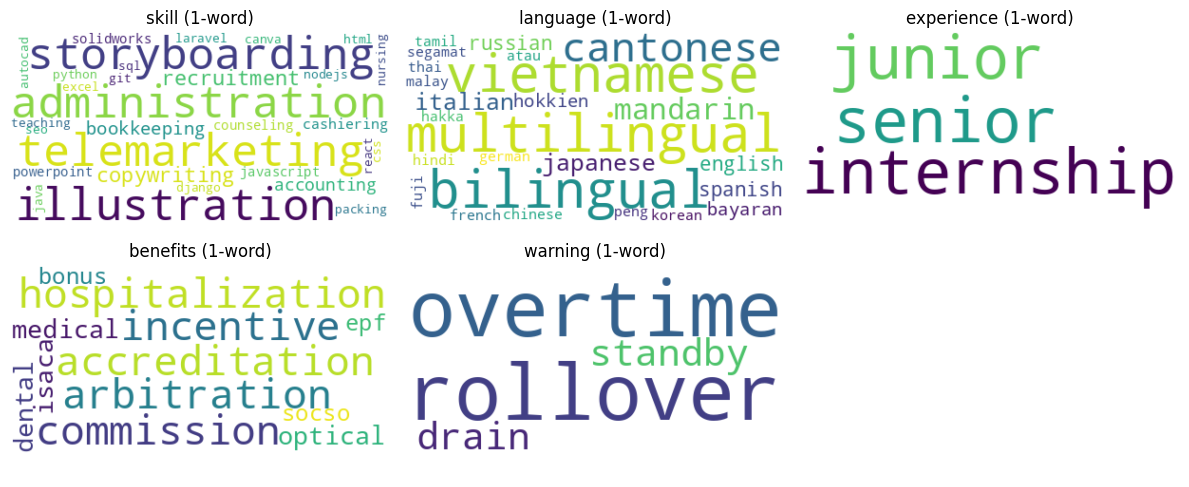

In [ ]:
from math import ceil
show_wordcloud_grid_by_length(expanded_keywords, n_words=1)


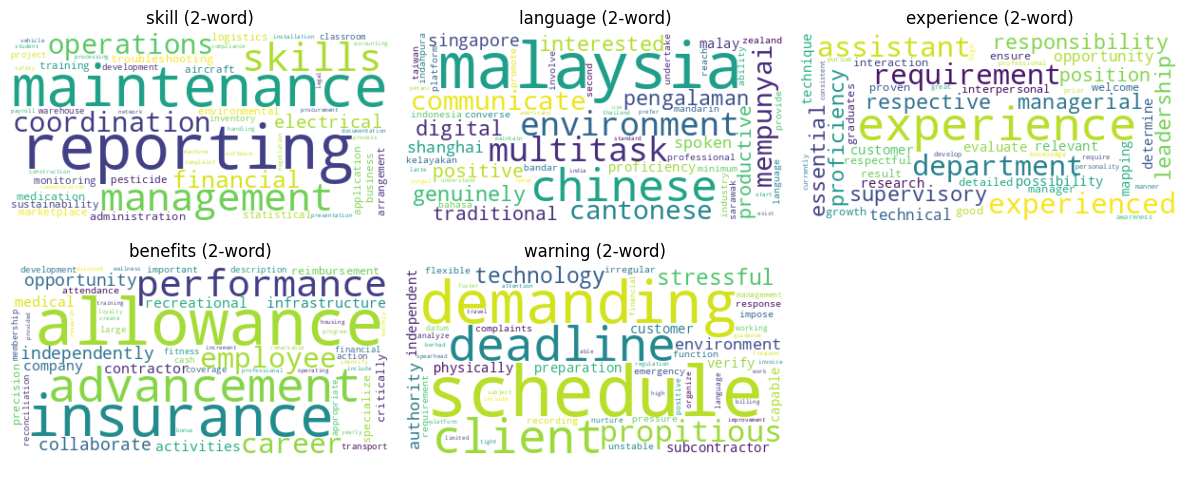

In [ ]:
show_wordcloud_grid_by_length(expanded_keywords, n_words=2)

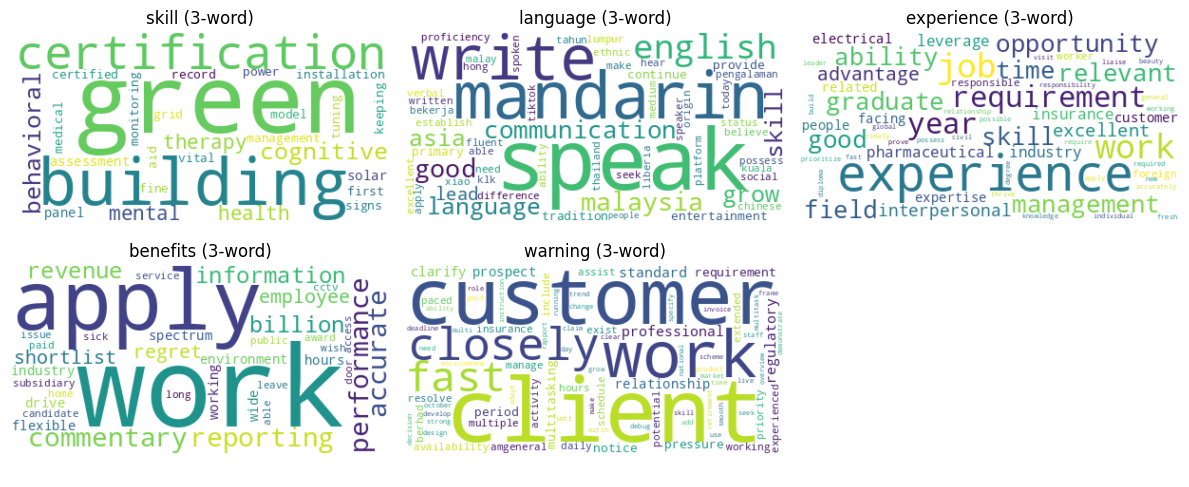

In [ ]:
show_wordcloud_grid_by_length(expanded_keywords, n_words=3)

###Label Distribution & Heatmap

In [ ]:
def show_label_distribution(df, label_cols):
    print("\nLabel Match Counts:")
    counts = df[label_cols].sum().sort_values(ascending=False)
    print(counts)
    counts.plot(kind='bar', title='Label Match Counts', figsize=(8, 4))
    plt.ylabel("Matched Rows")
    plt.show()

    print("\nMulti-label Correlation Heatmap:")
    corr = df[label_cols].corr()
    sns.heatmap(corr, annot=True, cmap="Blues")
    plt.title("Label Correlation Heatmap")
    plt.show()


Label Match Counts:
label_skill         64139
label_experience    62352
label_benefit       57743
label_warning       54984
label_language      53281
dtype: int64


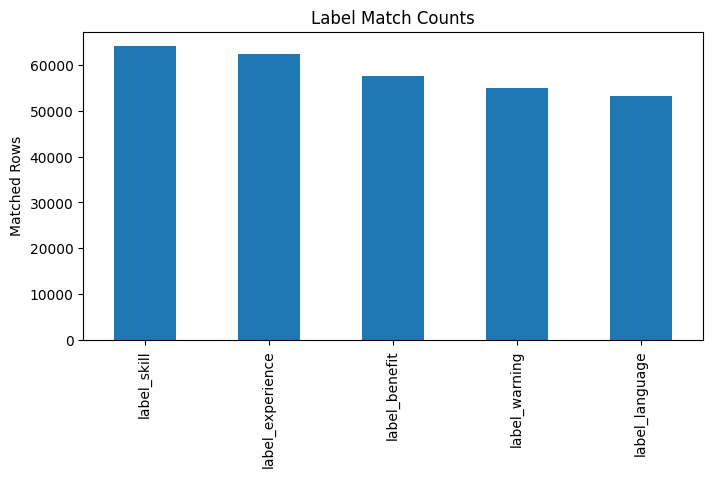


Multi-label Correlation Heatmap:


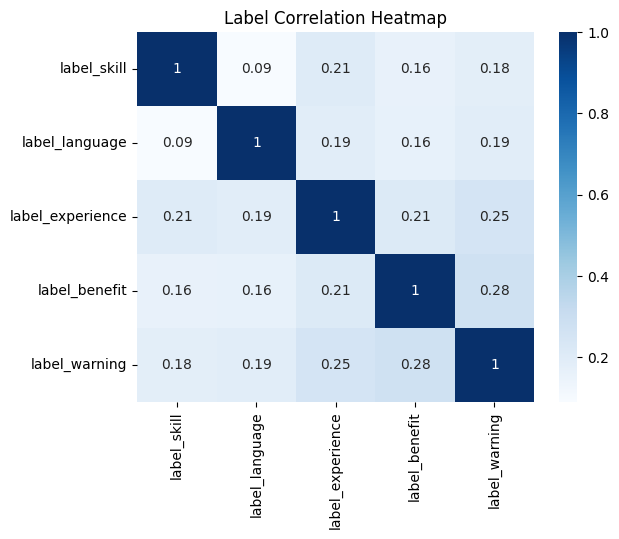

In [ ]:
    show_label_distribution(df, label_cols)


Label important **annotation** and then preprocessing data into these **label columns**

In [ ]:
df[label_cols]

,label_skill,label_language,label_experience,label_benefit,label_warning
0,True,True,True,True,True
1,True,True,True,True,True
2,True,False,False,True,True
3,True,True,True,True,True
4,True,True,True,True,True
...,...,...,...,...,...
65264,True,True,True,True,True
65265,True,True,True,True,True
65266,True,True,True,True,True
65267,True,True,True,True,True


Encode Descriptions and Prepare DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class JobDataset(Dataset):
    def __init__(self, df, tokenizer, text_col, label_cols, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.texts = df[text_col].tolist()
        self.labels = df[label_cols].values
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

dataset = JobDataset(df, tokenizer, 'clean_descriptions', label_cols, max_len=64)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
sample = dataset[0]
input_ids, attention_mask, labels_tensor = sample['input_ids'], sample['attention_mask'], sample['labels']
print("Input IDs shape:", input_ids.shape)
print("Attention mask shape:", attention_mask.shape)
print("Labels shape:", labels_tensor.shape)

Input IDs shape: torch.Size([64])
Attention mask shape: torch.Size([64])
Labels shape: torch.Size([5])


In [ ]:
from sklearn.model_selection import train_test_split
train_val_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.1, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.1, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


Train set size: 52867
Validation set size: 5875
Test set size: 6527


#Model Architecture

Define a BERT-based Model

In [ ]:
import torch.nn as nn
from transformers import AutoModel

class BertForMultiLabelClassification(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        cls_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        return self.classifier(cls_output)

MODEL_NAME = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model_clf = BertForMultiLabelClassification(MODEL_NAME, len(label_cols)).to(device)
optimizer = torch.optim.AdamW(model_clf.parameters(), lr=2e-4)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
print("Model Architecture:")
print(model_clf)

Model Architecture:
BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): Laye

In [ ]:
print("Trainable parameters:", sum(p.numel() for p in model_clf.parameters() if p.requires_grad))

Trainable parameters: 4403077


#Train and Apply Early Stoping

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    f1 = f1_score(all_labels, all_preds, average="micro")
    acc = accuracy_score(all_labels, all_preds)

    return total_loss / len(dataloader), f1, acc


In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    f1 = f1_score(all_labels, all_preds, average="micro")
    acc = accuracy_score(all_labels, all_preds)

    return total_loss / len(dataloader), f1, acc


In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model, path='best_model.pt'):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), path)
            print("Model saved.")
        else:
            self.counter += 1
            print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered.")


In [ ]:
def freeze_all_bert(model):
    for param in model.bert.parameters():
        param.requires_grad = False
    print("Phase 1: All BERT layers frozen.")

def unfreeze_last_bert_layers(model, layers=("layer.11", "pooler")):
    for name, param in model.bert.named_parameters():
        param.requires_grad = any(l in name for l in layers)
    print(f"Phase 2: Unfroze layers: {', '.join(layers)}")

from time import time
import gc
from sklearn.metrics import classification_report, roc_auc_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def final_evaluation(model, test_loader, device, label_cols):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels.cpu().numpy())

    preds_binary = (np.vstack(all_preds) > 0.5).astype(int)
    true_binary = np.vstack(all_labels).astype(int)


    return true_binary, preds_binary


def full_train_evaluate_pipeline(model, train_loader, val_loader, test_loader,
                                 optimizer, criterion, device, label_cols,
                                 phase1_epochs=3, phase2_epochs=5, patience=2,
                                 checkpoint_path="best_model.pt"):
    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []
    train_accs, val_accs = [], []
    early_stopper = EarlyStopping(patience=patience)
    start = time()

    # Phase 1
    freeze_all_bert(model)
    for epoch in range(phase1_epochs):
        print(f"\nPhase 1 - Epoch {epoch+1}")
        train_loss, train_f1, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1, val_acc = validate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        early_stopper(val_loss, model, path=checkpoint_path)
        if early_stopper.early_stop: break

    # Clean memory
    gc.collect()
    torch.cuda.empty_cache()

    # Phase 2
    unfreeze_last_bert_layers(model)
    early_stopper = EarlyStopping(patience=patience)
    for epoch in range(phase2_epochs):
        print(f"\nPhase 2 - Epoch {epoch+1}")
        train_loss, train_f1, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1, val_acc = validate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        early_stopper(val_loss, model, path=checkpoint_path)
        if early_stopper.early_stop: break

    print(f"\nTraining Time: {time() - start:.2f} sec")
    print(f"\nTrain F1: {train_f1s[-1]:.4f} | Val F1: {val_f1s[-1]:.4f}")
    print(f"\nTrain accuracy: {train_accs[-1]:.4f} | Val accuracy: {val_accs[-1]:.4f}")

    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # Final evaluation
    true_binary, preds_binary = final_evaluation(model, test_loader, device, label_cols)

    return model, train_losses, val_losses, train_f1s, val_f1s, train_accs, val_accs, true_binary, preds_binary


In [ ]:
model_clf, train_losses, val_losses, train_f1s, val_f1s, train_accs, val_accs, true_binary, preds_binary = full_train_evaluate_pipeline(
    model=model_clf,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    label_cols=label_cols,
    phase1_epochs=3,
    phase2_epochs=5,
    patience=2
)

Phase 1: All BERT layers frozen.

Phase 1 - Epoch 1


Validating: 100%|██████████| 368/368 [00:18<00:00, 20.40it/s]


Train Loss: 0.2967 | Val Loss: 0.2842
Model saved.

Phase 1 - Epoch 2


Validating: 100%|██████████| 368/368 [00:17<00:00, 20.95it/s]


Train Loss: 0.2885 | Val Loss: 0.2799
Model saved.

Phase 1 - Epoch 3


Validating: 100%|██████████| 368/368 [00:17<00:00, 21.01it/s]


Train Loss: 0.2867 | Val Loss: 0.2782
Model saved.
Phase 2: Unfroze layers: layer.11, pooler

Phase 2 - Epoch 1


Validating: 100%|██████████| 368/368 [00:19<00:00, 18.83it/s]


Train Loss: 0.2858 | Val Loss: 0.2775
Model saved.

Phase 2 - Epoch 2


Validating: 100%|██████████| 368/368 [00:17<00:00, 20.66it/s]


Train Loss: 0.2849 | Val Loss: 0.2767
Model saved.

Phase 2 - Epoch 3


Validating: 100%|██████████| 368/368 [00:17<00:00, 20.71it/s]


Train Loss: 0.2844 | Val Loss: 0.2759
Model saved.

Phase 2 - Epoch 4


Validating: 100%|██████████| 368/368 [00:19<00:00, 19.06it/s]


Train Loss: 0.2840 | Val Loss: 0.2757
Model saved.

Phase 2 - Epoch 5


Validating: 100%|██████████| 368/368 [00:18<00:00, 20.36it/s]


Train Loss: 0.2846 | Val Loss: 0.2755
Model saved.

Training Time: 1614.01 sec

Train F1: 0.9461 | Val F1: 0.9457

Train accuracy: 0.6618 | Val accuracy: 0.6643


#Evaluation & Insights

In [ ]:
model_clf.load_state_dict(torch.load("best_model.pt"))
model_clf.eval()

from sklearn.metrics import f1_score, accuracy_score

def evaluate_model(model, test_loader, device, threshold=0.5):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > threshold).astype(int)

            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    probs_concat = np.vstack(all_probs)
    preds_concat = np.vstack(all_preds)
    labels_concat = np.vstack(all_labels)

    return labels_concat, preds_concat, probs_concat

true_binary, preds_binary, preds_proba = evaluate_model(
    model=model_clf,
    test_loader=test_loader,
    device=device,
    threshold=0.5
)



#### 1. Plot Results

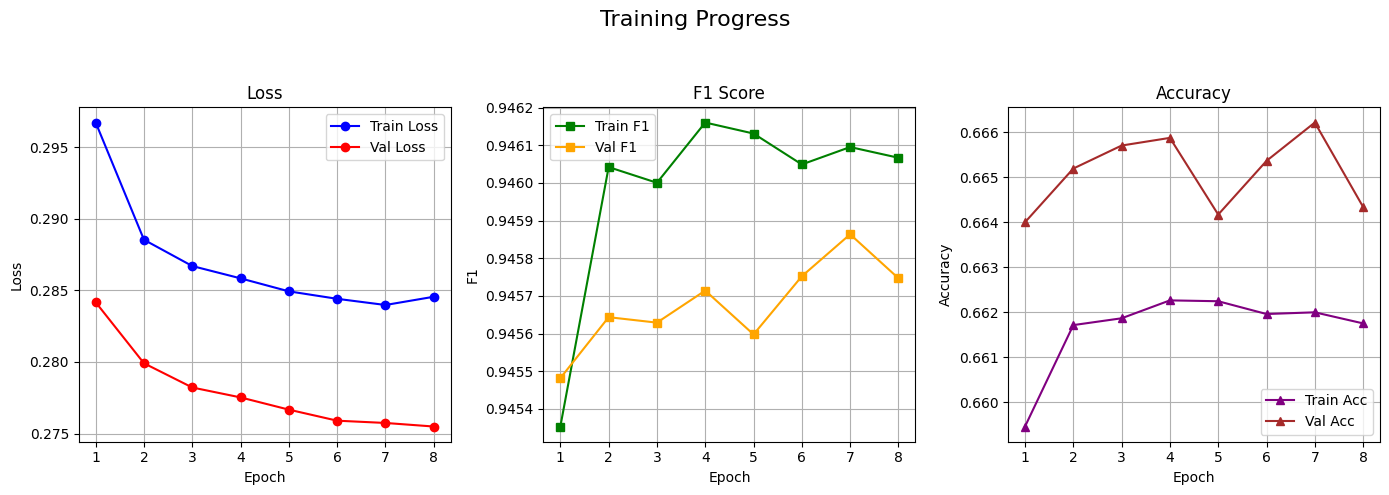

In [ ]:
def plot_full_training_results(train_losses, val_losses, train_f1s, val_f1s, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.suptitle("Training Progress", fontsize=16)

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o', color='red')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # F1 Score Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_f1s, label='Train F1', marker='s', color='green')
    plt.plot(epochs, val_f1s, label='Val F1', marker='s', color='orange')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_accs, label='Train Acc', marker='^', color='purple')
    plt.plot(epochs, val_accs, label='Val Acc', marker='^', color='brown')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

plot_full_training_results(train_losses, val_losses, train_f1s, val_f1s, train_accs, val_accs)

####2. Classification Report

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def run_classification_report(true_binary, preds_binary, label_cols):
    print("Classification Report:")
    print(classification_report(true_binary, preds_binary, target_names=label_cols))
    print("ROC-AUC (macro):", roc_auc_score(true_binary, preds_proba, average="macro"))


run_classification_report(true_binary, preds_binary, label_cols)


Classification Report:
                  precision    recall  f1-score   support

     label_skill       0.98      1.00      0.99      6418
  label_language       0.82      1.00      0.90      5333
label_experience       0.96      1.00      0.98      6257
   label_benefit       0.89      1.00      0.94      5766
   label_warning       0.85      1.00      0.92      5498

       micro avg       0.90      1.00      0.95     29272
       macro avg       0.90      1.00      0.94     29272
    weighted avg       0.90      1.00      0.95     29272
     samples avg       0.90      1.00      0.93     29272

ROC-AUC (macro): 0.7549846273565292


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 3. Plot Keywords Correlation

<ipython-input-60-1253343856>:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(keyword_matrix[:, kw_idx], y_true_test[:, label_idx])


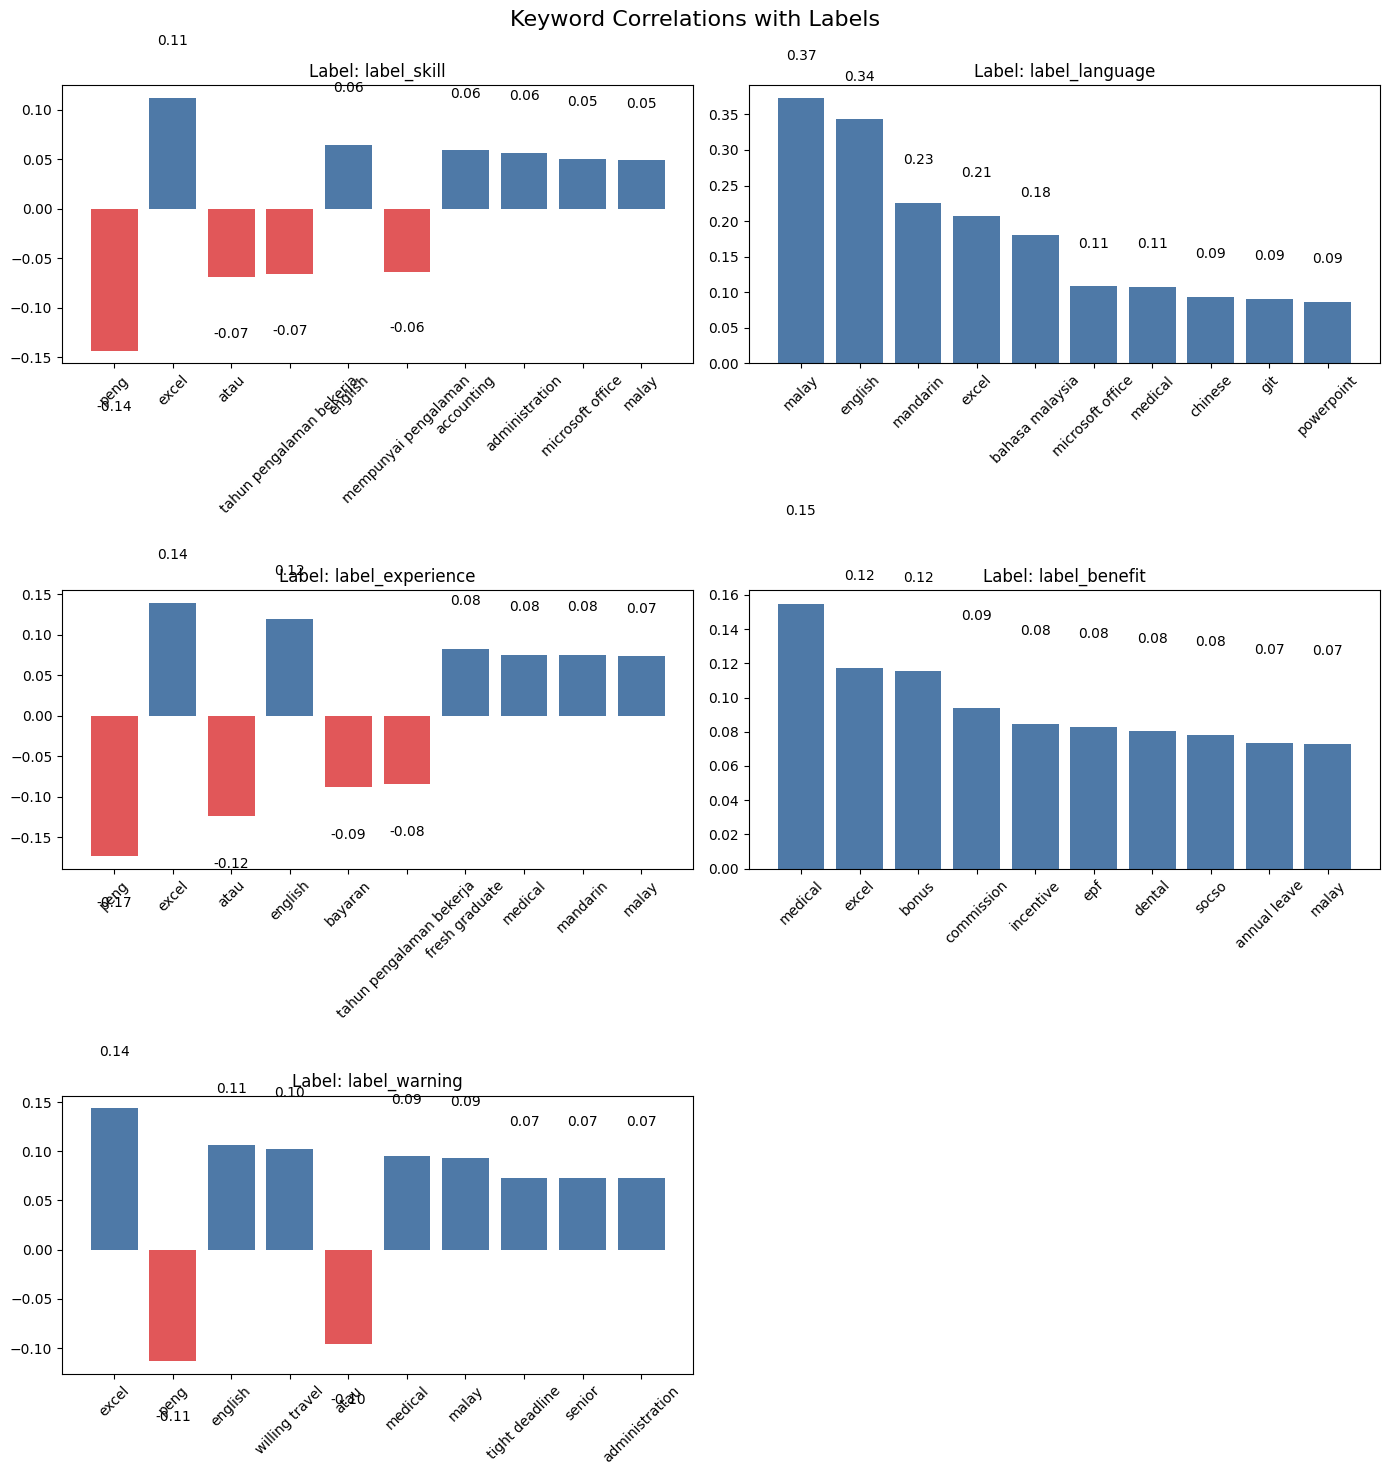


Correlation analysis using 6527 test samples and 558 keywords (ngram match: True).

Total keyword matches in matrix: 30523


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 ['vietnamese',
  'deadline adapt change',
  'career development',
  'cctv door access',
  'menu knowledge',
  'assist resolve customer',
  'night shift',
  'fast grow group',
  'training coordination',
  'seek mandarin speak',
  'wellness program',
  'shift work',
  'prior experience',
  'admin support',
  'tiktok xiao hong',
  'incentive',
  'statistical reporting',
  'presentation skills',
  'position opportunity',
  'management datum',
  'continue tradition provide',
  'internship',
  'monthly operating',
  'nodejs',
  'opportunity advancement',
  'aircraft maintenance',
  'malaysia start',
  'green building certification',
  'fast evolve',
  'client need goal',
  'verify purchase',
  'work experience general',
  'python',
  'department 

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import re

def plot_keyword_correlation(df, label_cols, expanded_keywords, test_indices, top_k=10, ngram_match=True):
    all_keywords = set(kw for kws in expanded_keywords.values() for kw in kws)
    texts = df['clean_descriptions'].iloc[test_indices].tolist()
    y_true_test = df[label_cols].iloc[test_indices].values

    keyword_matrix = np.zeros((len(texts), len(all_keywords)))
    keyword_list = list(all_keywords)

    for i, text in enumerate(texts):
        text_lower = text.lower()
        for j, keyword in enumerate(keyword_list):
          if len(keyword) < 2:
              continue
          if ngram_match:
              if keyword in text_lower:
                  keyword_matrix[i, j] = 1
          else:
              if re.search(r'\\b' + re.escape(keyword) + r'\\b', text_lower):
                  keyword_matrix[i, j] = 1



    correlations = {label: [] for label in label_cols}
    for label_idx, label in enumerate(label_cols):
        for kw_idx, keyword in enumerate(keyword_list):
            corr, _ = pearsonr(keyword_matrix[:, kw_idx], y_true_test[:, label_idx])
            if not np.isnan(corr):
                correlations[label].append((keyword, corr))

    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    fig.suptitle("Keyword Correlations with Labels", fontsize=16)
    axes = axes.flatten()

    for label_idx, label in enumerate(label_cols):
        sorted_corrs = sorted(correlations[label], key=lambda x: abs(x[1]), reverse=True)[:top_k]
        keywords = [kw for kw, _ in sorted_corrs]
        corrs = [corr for _, corr in sorted_corrs]
        bars = axes[label_idx].bar(keywords, corrs, color=['#4e79a7' if c >= 0 else '#e15759' for c in corrs])
        axes[label_idx].set_title(f'Label: {label}')
        axes[label_idx].tick_params(axis='x', rotation=45)
        for bar in bars:
            height = bar.get_height()
            axes[label_idx].text(bar.get_x() + bar.get_width()/2, height + (0.05 if height >= 0 else -0.05),
                                 f'{height:.2f}', ha='center', va='bottom' if height >= 0 else 'top')

    for ax in axes[len(label_cols):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    print(f"\nCorrelation analysis using {len(texts)} test samples and {len(all_keywords)} keywords (ngram match: {ngram_match}).")
    print(f"\nTotal keyword matches in matrix: {int(keyword_matrix.sum())}")

    return keyword_matrix, keyword_list



plot_keyword_correlation(
    df,
    label_cols,
    expanded_keywords,
    test_dataset.indices,
    top_k=10,
    ngram_match=True
)



<ipython-input-60-1253343856>:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(keyword_matrix[:, kw_idx], y_true_test[:, label_idx])


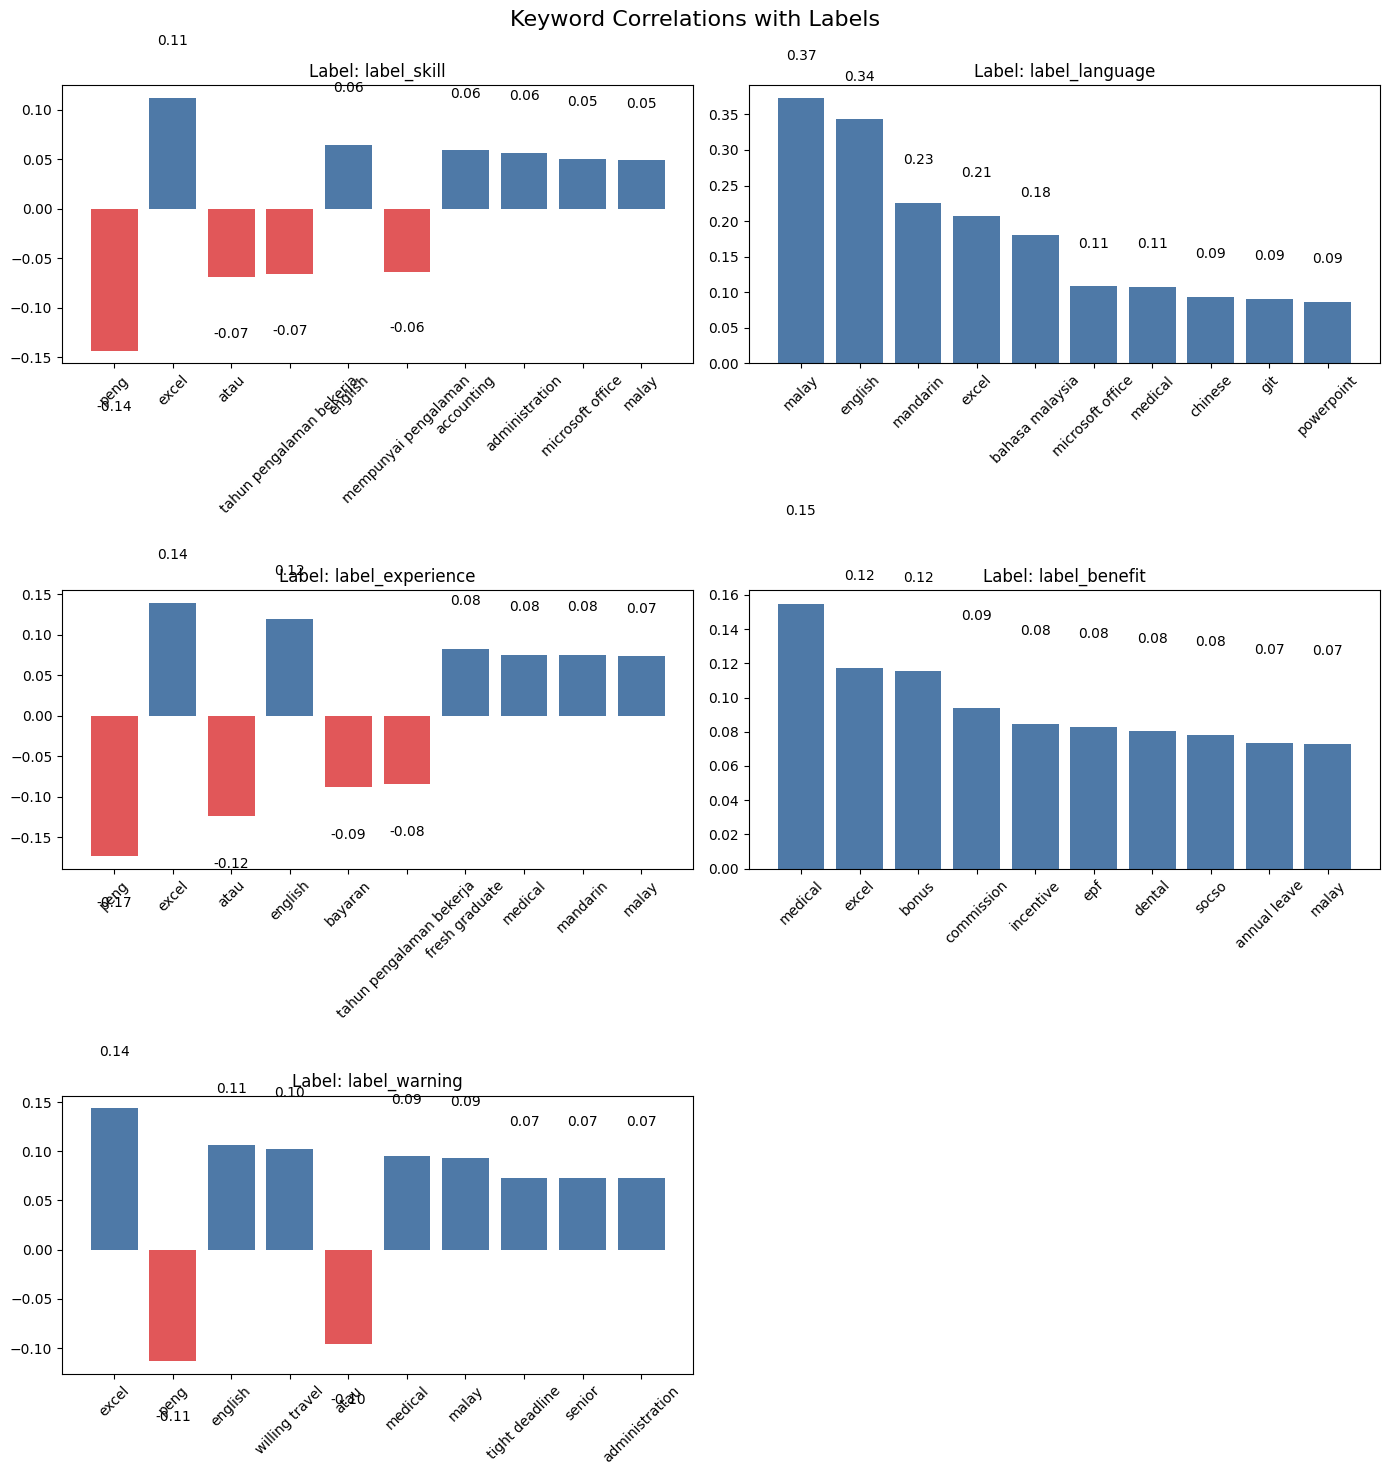


Correlation analysis using 6527 test samples and 558 keywords (ngram match: True).

Total keyword matches in matrix: 30523
Top 10 most matched keywords:
excel: 2772
malay: 2499
english: 2248
mandarin: 1209
accounting: 1107
administration: 1035
medical: 1005
fresh graduate: 900
microsoft office: 840
bahasa malaysia: 824


In [ ]:
kw_matrix, kw_list = plot_keyword_correlation(
    df,
    label_cols,
    expanded_keywords,
    test_dataset.indices,
    top_k=10,
    ngram_match=True
)

top_kw_counts = kw_matrix.sum(axis=0)
sorted_counts = sorted(zip(kw_list, top_kw_counts), key=lambda x: -x[1])
print("Top 10 most matched keywords:")
for word, count in sorted_counts[:10]:
    print(f"{word}: {int(count)}")


##### 4. Confusion Matrix (for each label)


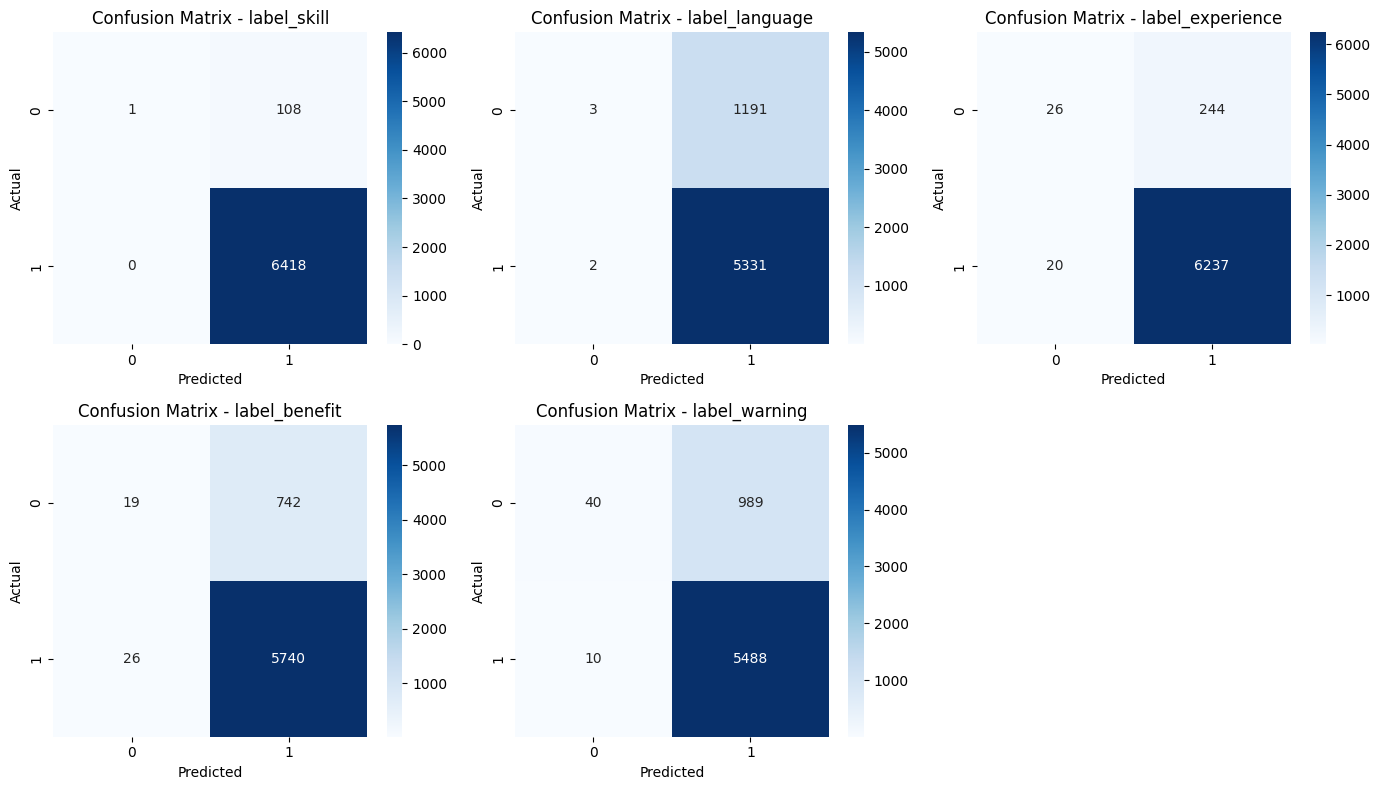

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(true_binary, preds_binary, label_cols):
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()

    cms = multilabel_confusion_matrix(true_binary, preds_binary)

    for i, label in enumerate(label_cols):
        sns.heatmap(cms[i], annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"Confusion Matrix - {label}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    # Hide unused subplot if label count < 6
    for j in range(len(label_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(true_binary, preds_binary, label_cols)

###5. ROC-AUC

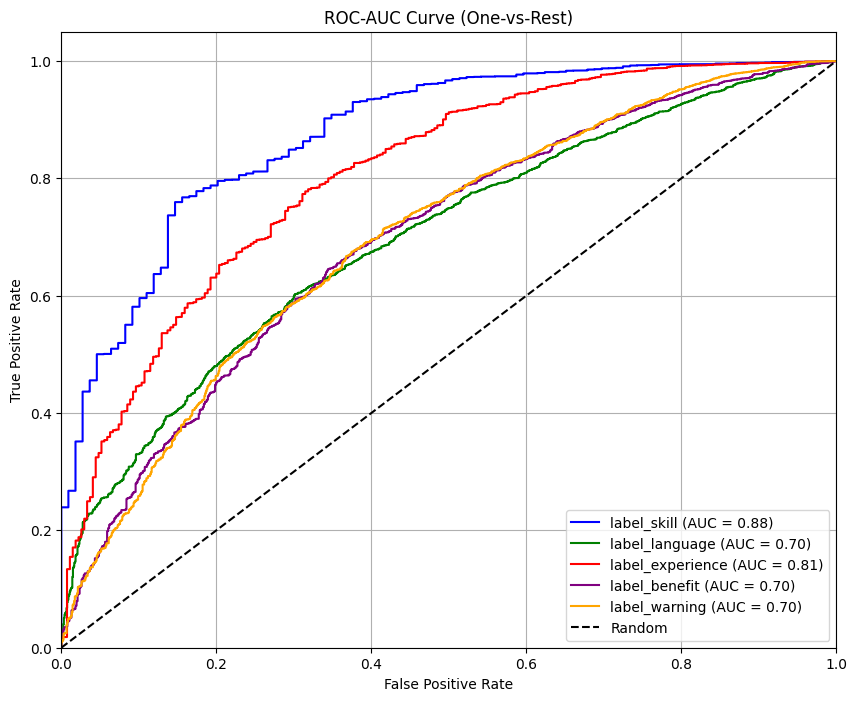

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc_fixed(true_binary, probs, label_cols):
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i, label in enumerate(label_cols):
        fpr, tpr, _ = roc_curve(true_binary[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})", color=colors[i])

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_auc_fixed(true_binary, preds_proba, label_cols)


## Inference and Job Preference Suggestion

- Predict labels for new texts, using keyword features to enhance predictions.
- Suggest job roles based on predicted labels and detected keywords.

In [ ]:
class JobClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)

def load_model():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = JobClassifier(MODEL_NAME, len(label_cols)).to(device)
    checkpoint = torch.load("/content/drive/MyDrive/best_model.pt", map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    return tokenizer, model

def predict_single(text, tokenizer, model, device):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        logits = model(**inputs)
        if logits is None:
            raise ValueError("Model returned None. Check forward method.")
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        preds = (probs > 0.5).astype(int)
    return preds, probs

# Load model for this script context
tokenizer, model = load_model()

# Example predictions (batch test)
examples = [
    "Recent graduate looking for an entry-level position with minimal experience requirements.",
    "Over 10 years of senior experience in data engineering and cloud computing, skilled in Python, AWS, and Kubernetes.",
    "Fluent in English, Mandarin, and German, seeking roles that utilize multilingual communication skills.",
    "Experienced emergency room nurse, accustomed to high-pressure environments and rapid decision making.",
    "Looking for a new opportunity in a dynamic company. Open to various roles."
]

for i, sample_text in enumerate(examples, 1):
    preds, probs = predict_single(sample_text, tokenizer, model, device)
    pred_dict, prob_dict, suggestions = suggest_job(preds, probs, label_cols)

    print(f"\n--- Example {i} ---")
    print("Input:", sample_text)
    print("Predicted Labels:", pred_dict)
    print("Probabilities:", {k: f'{v:.4f}' for k, v in prob_dict.items()})
    print("Job Suggestions:")
    for s in suggestions:
        print(f"- {s}")


--- Example 1 ---
Input: Recent graduate looking for an entry-level position with minimal experience requirements.
Predicted Labels: {'label_skill': np.int64(1), 'label_language': np.int64(0), 'label_experience': np.int64(0), 'label_benefit': np.int64(0), 'label_warning': np.int64(0)}
Probabilities: {'label_skill': '0.9998', 'label_language': '0.3042', 'label_experience': '0.4133', 'label_benefit': '0.1602', 'label_warning': '0.1938'}
Job Suggestions:
- General Role (No specific preferences identified)

--- Example 2 ---
Input: Over 10 years of senior experience in data engineering and cloud computing, skilled in Python, AWS, and Kubernetes.
Predicted Labels: {'label_skill': np.int64(1), 'label_language': np.int64(0), 'label_experience': np.int64(0), 'label_benefit': np.int64(0), 'label_warning': np.int64(0)}
Probabilities: {'label_skill': '0.9998', 'label_language': '0.2739', 'label_experience': '0.2600', 'label_benefit': '0.0753', 'label_warning': '0.0732'}
Job Suggestions:
- Genera